In [2]:
import gym
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from pprint import pprint
import utils
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [5]:
class Env():
    def __init__(self, envname='Pendulum-v0'):
        self.env = gym.make(envname)
        self.obs = self.env.reset()
        self.fix_obs()
    def step(self, act):
        a, other = act(self.obs)
        old_obs = self.obs
        obs, r, d, _ = self.env.step(a.squeeze(0))
        r = torch.tensor([[r]], dtype=torch.float)
        d = torch.tensor([[d]], dtype=torch.float)
        self.obs = obs
        self.fix_obs()
        obs = self.obs
        if d.item() > 1e-5:
            self.obs = self.env.reset()
            self.fix_obs()
        #elf.env.render()
        
        return old_obs, obs, r, d, a, other
    def fix_obs(self):
        try:
            self.obs.shape[1]
        except:
            self.obs = np.expand_dims(self.obs, axis=0)
    
class Envs():
    def __init__(self, n_envs=200):
        self.envs = [Env() for i in range(n_envs)]
        self.n_envs = n_envs
    def step(self, pi, debug=False):
        old_obs, obs, r, d, a, (logprob, smpl, _) = self.envs[0].step(pi)
        for env in self.envs[1:]:
            old_obst, obst, rt, dt, at, (logprobt, smplt, _) = env.step(pi)
            try:
                old_obs = np.concatenate((old_obs, old_obst), axis=0)
            except:
                print(old_obs.shape, old_obst.shape)
                old_obs = np.concatenate((old_obs, old_obst), axis=0)
            obs     = np.concatenate((obs, obst), axis=0)
            r = torch.cat((r, rt), dim=0)
            d = torch.cat((d, dt), dim=0)
            a = np.concatenate((a, at), axis=0)
            logprob = torch.cat((logprob, logprobt), dim=0)
            smpl = torch.cat((smpl, smplt), dim=0)
            
        old_obs = torch.tensor(old_obs, dtype=torch.float).detach()
        obs     = torch.tensor(obs, dtype=torch.float).detach()
        a = torch.tensor(a, dtype=torch.float).detach()
        logprob = logprob.unsqueeze(-1)
        if debug:
            print(smpl.shape, old_obs.shape, a.shape, r.shape, obs.shape, d.shape, logprob.shape)
        return old_obs, a, r, obs, d, smpl, logprob
    def evenout(self):
        pi = lambda x:(np.array([[0]]), -1)
        for i, env in enumerate(self.envs):
            print(i, "/", self.n_envs, end='\r')
            for j in range(i+2):
#                 print(i, j)
                _ = env.step(pi)
            
        
        
    
import gym
import numpy as np
envs1 = Envs()
envs1.evenout()
old_obs, a, r, obs, d, smpls, logprobs = envs1.step(agent.act, debug=True)
old_obs, a, r, obs, d, smpls, logprobs = envs1.step(agent.act, debug=True)
# print("0bs1", obs, "\noldobs1", old_obs)
# old_obs, a, r, obs, d, _, _ = envs.step(agent.act, debug=True)
# print("obs2", obs, "\noldobs2", old_obs)
# old_obs, a, r, obs, d, _, _ = envs.step(agent.act, debug=True)

torch.Size([200, 1]) torch.Size([200, 3]) torch.Size([200, 1]) torch.Size([200, 1]) torch.Size([200, 3]) torch.Size([200, 1]) torch.Size([200, 1])
torch.Size([200, 1]) torch.Size([200, 3]) torch.Size([200, 1]) torch.Size([200, 1]) torch.Size([200, 3]) torch.Size([200, 1]) torch.Size([200, 1])


In [3]:
class Agent(nn.Module):
    def __init__(self, idim, h1dim, odim, nbins=20):
        super().__init__()
        self.lin1 = nn.Linear(idim, h1dim)
        self.lin2 = nn.Linear(h1dim, nbins*odim)
        self.nbins = nbins
        self.odim = odim
        mmax = 200000
        l = list(range(-mmax, mmax, 2*mmax//nbins))
        self.cvt = torch.tensor(l, dtype=torch.float) / mmax * 2
        print(self.cvt)
    def forward(self, x):
        h = self.lin1(x)
        h = F.relu(h)
        h = self.lin2(h)
        h = h.view(h.shape[0], -1, self.nbins)
        h = torch.softmax(h, dim=-1)
        return h
    def act(self, o, smpl=None):
        o = torch.tensor(o, dtype=torch.float)
#         if o.shape[-1] == 1:
#             o = o.squeeze(-1)
#         print(o.shape)
        h = self.forward(o)
        dis = torch.distributions.Categorical(h)
        if smpl == None:
            smpl = dis.sample()
        a = self.cvt[smpl.long()].detach().numpy()
        if a.shape == np.array(1).shape:
            a = np.array([a])
        #print("logprob", dis.log_prob(smpl).shape)
        return a, (dis.log_prob(smpl).sum(dim=-1), smpl, h)
    
class Critic(nn.Module):
    def __init__(self, idim, h1dim, odim):
        super().__init__()
        self.lin1 = nn.Linear(idim, h1dim)
        self.lin2 = nn.Linear(h1dim, odim)
    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float)
        h = self.lin1(x)
        h = F.relu(h)
        h = self.lin2(h)
        return h

In [4]:
env = gym.make('Pendulum-v0')
idim = env.observation_space.shape[0]
odim = env.action_space.shape[0]
print(odim)
agent = Agent(idim, 10, odim, 8)
critic = Critic(idim, 10, 1)

rvec = np.random.randn(1, idim)
a, (p, _, h) = agent.act(rvec)
a2, __ = agent.act(rvec, _)
a.shape, p.shape, _.shape, h.shape

1
tensor([-2.0000, -1.5000, -1.0000, -0.5000,  0.0000,  0.5000,  1.0000,  1.5000])


((1, 1), torch.Size([1]), torch.Size([1, 1]), torch.Size([1, 1, 8]))

In [49]:
def showit():
    observation = env.reset()
    for t in range(200):
            env.render()
            obser = np.expand_dims(observation, axis=0)
            action, _= agent.act(obser)
            #print(action, _)
            observation, reward, done, info = env.step(action.squeeze(0))
            if done:
                break
            time.sleep(0.005)
            print(t, "/200", end='\r')
showit()

env.close()
cv2.destroyAllWindows()

In [44]:
sid = 10
torch.manual_seed(sid)
np.random.seed(sid)
idim = env.observation_space.shape[0]
odim = env.action_space.shape[0]
agent = Agent(idim, 10, odim, 10)
critic = Critic(idim, 10, 1)
copt = torch.optim.Adam(critic.parameters(), lr=2e-3)
aopt = torch.optim.Adam(agent.parameters() , lr=5e-2)
import copy
tcritic = copy.deepcopy(critic)

tensor([-2.0000, -1.6000, -1.2000, -0.8000, -0.4000,  0.0000,  0.4000,  0.8000,
         1.2000,  1.6000])


In [45]:
env.close()
cv2.destroyAllWindows()
gamma = 0.9

gmm = torch.zeros(200, 200, dtype=torch.float)
for i in range(gmm.shape[0]):
    umn = 1
    for j in range(i, gmm.shape[1]):
        gmm[i, j] = umn
        umn *= gamma

In [50]:
mean_rs = []; mean_td = []; mean_loss = []
eps = 300000
lptd =  LowPassFilter(1-1/50)
lplo = LowPassFilter(1-1/50)
lpr  = LowPassFilter(1-1/50)
lpl1 = LowPassFilter(1-1/50)
lpl2 = LowPassFilter(1-1/50)
lpclip = LowPassFilter(1-1/30)

envs = Envs(200)
envs.evenout()

torch.set_printoptions(edgeitems=3000)
for ep in range(eps):
    old_obs, a, r, obs, d, smpls, oldprobs = envs.step(agent.act, debug=False)
    mean_rs.append(r.mean().item())
    lpr.step(mean_rs[-1])
    if lpr.val > -1.91:
        print("over in ", ep, "steps, last mean reward is", mean_rs[-1], " current mean reward is", lpr.val)
        print(lpr.val)
        break
    
    entropymul = max(max(1-ep/1000, 0.35)*0.5, 0.3)
    adv = r + gamma*tcritic(obs).detach() - tcritic(old_obs).detach()
    if lptd.val<10:
        for i in range(8):
            _, (newprobs, _, ps) = agent.act(old_obs, smpl=smpls)
            ratio = torch.exp(newprobs.unsqueeze(-1)-oldprobs.detach())
            radv = ratio*adv
            e= 0.1
            l1 = -torch.min(radv, torch.clamp(ratio, 1-e, 1+e)*adv).mean()
            clipped = (ratio != torch.clamp(ratio, 1-e, 1+e)).float().mean()
    #         print(clipped, radv, torch.clamp(radv, 1-e, 1+e))
            lpclip.step(clipped.item())
            l2 = -torch.log(ps+1e-8).mean()
            loss = l1 + torch.abs(l1.detach()/l2.detach())*l2*entropymul*0.1
            aopt.zero_grad()
            loss.backward()
            aopt.step()
            lpl1.step(l1.item()); lpl2.step(l2.item())
            lplo.step(loss.item()); mean_loss.append(lplo.val)
        
    for i in range(4):
        td_error = ((r - critic(old_obs) + gamma*tcritic(obs).detach())**2).mean()
        copt.zero_grad()
        td_error.backward()
        copt.step()
        lptd.step(torch.sqrt(td_error).item()); mean_td.append(lptd.val)
        
    if ep%10==0:
        mprint("ep", ep, "loss", lplo.val, "TD", lptd.val, "rmean", lpr.val, "l1", lpl1.val, "l2", lpl2.val, "emul", entropymul, "clip", lpclip.val)
    if ep%40==0:
        showit()
    polyak(critic, tcritic, 1-1/200)
#     if ep%40==0:
#         tcritic = copy.deepcopy(critic)
    
    
env.close()
cv2.destroyAllWindows()

ep=0.00000   loss=0.47790   TD=1.88094   rmean=-6.15760   l1=0.45514   l2=2.89093   emul=0.50000   clip=0.01257   


<ipython-input-3-2dd26265744c>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float)
<ipython-input-3-2dd26265744c>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  o = torch.tensor(o, dtype=torch.float)


ep=10.00000   loss=0.42545   TD=1.69119   rmean=-6.11981   l1=0.40529   l2=2.85828   emul=0.49500   clip=0.07111   
ep=20.00000   loss=0.43119   TD=1.57886   rmean=-6.11617   l1=0.41094   l2=2.86402   emul=0.49000   clip=0.09610   
ep=30.00000   loss=0.47726   TD=1.53382   rmean=-6.13256   l1=0.45507   l2=3.05220   emul=0.48500   clip=0.06075   
ep=40.00000   loss=0.60983   TD=1.55363   rmean=-6.16877   l1=0.58176   l2=3.11078   emul=0.48000   clip=0.01618   
ep=50.00000   loss=0.59819   TD=1.56519   rmean=-6.20305   l1=0.57090   l2=3.15020   emul=0.47500   clip=0.06377   
ep=60.00000   loss=0.80639   TD=1.56479   rmean=-6.22939   l1=0.77002   l2=3.23590   emul=0.47000   clip=0.04987   
ep=70.00000   loss=0.82089   TD=1.55397   rmean=-6.29707   l1=0.78423   l2=3.60727   emul=0.46500   clip=0.05507   
ep=80.00000   loss=1.19276   TD=1.51246   rmean=-6.35116   l1=1.14004   l2=3.55725   emul=0.46000   clip=0.12406   
ep=90.00000   loss=1.13251   TD=1.44102   rmean=-6.41184   l1=1.08294   

KeyboardInterrupt: 

Text(0, 0.5, 'mean loss')

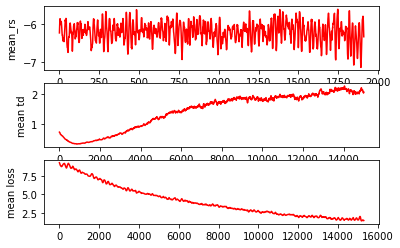

In [22]:
plt.subplot(3, 1, 1)
plt.plot(mean_rs, "r")
plt.ylabel('mean_rs')
plt.subplot(3, 1, 2)
plt.plot(mean_td[300:], "r")
plt.ylabel("mean td")
plt.subplot(3, 1, 3)
plt.plot(mean_loss, "r")
plt.ylabel("mean loss")

In [107]:
torch.save(agent.state_dict(), "agent.ph")
torch.save(critic.state_dict(), "critic.ph")

In [108]:
agent.load_state_dict(torch.load("agent.ph"))
critic.load_state_dict(torch.load("critic.ph"))

<All keys matched successfully>

In [12]:
def polyak(a, b, alfa=0.99):
    for namea, parama in a.named_parameters():
        for nameb, paramb in b.named_parameters():
            if namea == nameb:
                paramb.data = paramb.data*alfa + parama.data*(1-alfa)
    return b

In [13]:
def mprint(*args):
    pr = ""
    args = [[args[i*2], args[i*2+1]] for i in range(len(args)//2)]
    for name, arg in args:
        if name == None:
            name = "nnone"
        pr += name + "="
        if type(arg) == int:
            arg = float(arg)
        try:
            arg = arg.item()
        except:
            nista = True
        if type(arg) == float:
            pr += format(arg, '5.5f') + "   "
        else:
            pr += str(arg) + "   "
    print(pr)

In [14]:
class LowPassFilter():
    def __init__(self, alfa):
        self.init_value = -123456
        self.val = self.init_value
        self.alfa = alfa
        self.notbin = True
    def step(self, newval):
        if self.notbin:
            self.val = newval
            self.notbin = False
        self.val = self.val*self.alfa + newval*(1-self.alfa)